In [1]:
import os
import sys

import pandas as pd

import rbm_torch.utils.data_prep as dp
import rbm_torch.analysis.analysis_methods as am
from copy import copy

/home/jonah/anaconda3/envs/aptamer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mid_pd = pd.read_csv("./cov/cov_7_to_9_ct.csv")
low_pd = pd.read_csv("./cov/cov_4_to_6_ct.csv")
high_pd = pd.read_csv("./cov/cov_10_to_12_ct.csv")


cov_mid = mid_pd
cov_low = low_pd
cov_high = high_pd

all_seqs_pd = pd.merge(pd.merge(high_pd, mid_pd, how='outer', left_on='sequence', right_on='sequence'), low_pd, how='outer', left_on='sequence', right_on='sequence')

In [3]:
full_data = am.fetch_data([f"r{i}" for i in range(2, 13)], dir="./cov/raw_rounds/", threads=12)
count_millions = {}
for r in [f"r{i}" for i in range(2, 13)]:
    data = full_data[full_data["round"] == r]
    count_millions[r] = data["copy_num"].sum()/1000000

for r in [f"r{i}" for i in range(4, 13)]:
    all_seqs_pd[r] = all_seqs_pd[r].div(count_millions[r])


Process Time 6.69028377532959
Process Time 0.4420316219329834
Process Time 0.3324129581451416
Process Time 1.4992260932922363
Process Time 1.008871078491211
Process Time 1.7214107513427734
Process Time 0.5854949951171875
Process Time 0.16218996047973633
Process Time 0.43220973014831543
Process Time 0.20170950889587402
Process Time 0.4499368667602539


In [4]:
def exclusive_rows(key_pd, query_pd, col_val):
    """returns rows in key pd that are not in query pd"""
    df_all = key_pd.merge(query_pd.drop_duplicates(), on=col_val, how='left', indicator=True)
    df_subset = copy(df_all[df_all['_merge'] == 'left_only'])
    return df_subset.drop("_merge", axis=1)

In [8]:
round_names = ["r9", "r10", "r11", "r12"]
max_diff = None
min_diff = 1
diff_weights = [0.95, 1.0, 1.02]
round_weights = [0.95, 0.98, 1.01, 1.03]

late_round = (all_seqs_pd["r9"].notnull()) | (all_seqs_pd["r10"].notnull()) | (all_seqs_pd["r11"].notnull()) | (all_seqs_pd["r12"].notnull())
gstring = all_seqs_pd.apply(lambda row: "GGGGGG" in row["sequence"], axis=1)
cstring = all_seqs_pd.apply(lambda row: "CCCCCC" in row["sequence"], axis=1)

ndf = enrichment_averge(copy(all_seqs_pd[late_round & ~gstring & ~cstring]), round_names, min_diff=1, diff_weights=diff_weights, round_weights=round_weights)
# ndf["fitness_value"] = dp.scale_values_np(dp.log_scale(ndf["Final_Fold_Avg"].to_list(), eps=1, base=10), min=0.1, max=1.0).squeeze(1).tolist()

dp.dataframe_to_fasta(ndf, "./cov/late_5gcmax_raw.fasta", count_key="Final_Fold_Avg")

In [7]:
ndf.head()

,sequence,r10,r11,r12,r7,r8,r9,r4,r5,r6,fold_r10vr9,fold_r11vr9,fold_r12vr9,fold_r11vr10,fold_r12vr10,fold_r12vr11,fold_diff1_avg,fold_diff2_avg,fold_diff3_avg,Final_Fold_Avg
12,GTGGGTACGGGACACTTGCTTCTGGGGGTGGAGGTTGGGC,0.582342,0.345661,0.125674,0.239656,0.814923,0.502573,NaN,NaN,NaN,2.236334,1.348055,0.495119,1.181205,0.433772,0.741692,1.317090,0.890913,0.505022,0.904342
18,TCTGGGGGTGGGTTCGGGTATGGGGTCTGCACTATGGCTC,0.145586,0.345661,0.125674,0.047931,0.232835,0.502573,NaN,NaN,NaN,0.559083,1.348055,0.495119,4.724819,1.735088,0.741692,1.908105,1.541571,0.505022,1.318233
19,GGCGCGGCCGCCCCCGGGCCACACCAAAACACGCTCAACT,0.145586,0.345661,0.125674,NaN,NaN,0.502573,NaN,NaN,NaN,0.559083,1.348055,0.495119,4.724819,1.735088,0.741692,1.908105,1.541571,0.505022,1.318233
28,GGGGGCGGGGCCCCCGGGCCACACCATAACACGTTCAACT,0.291171,0.345661,0.125674,NaN,NaN,0.502573,NaN,NaN,NaN,1.118167,1.348055,0.495119,2.362409,0.867544,0.741692,1.337052,1.107799,0.505022,0.983291
33,TGCCACGTAAAACGCAACACCAAACACGTACCGCACCAAC,0.145586,0.345661,0.251347,0.191725,0.232835,0.502573,NaN,NaN,NaN,0.559083,1.348055,0.990239,4.724819,3.470175,1.483384,2.142974,2.409115,1.010044,1.854044


In [12]:
import math
import numpy as np
ndf_seqs = ndf["sequence"].to_list()
ndf_ea = ndf["Final_Fold_Avg"].to_list()
adj_seqs = []
for sid, seq in enumerate(ndf_seqs):
    adj_seqs += [seq] * math.floor(ndf_ea[sid])

affs = list(np.full(len(adj_seqs), 1.))

# dp.write_fasta(adj_seqs, affs, "./cov/enriched_dataset_full.fasta")
dp.write_fasta(adj_seqs, affs, "./cov/enriched_dataset_full_nog_noc.fasta")

In [20]:
mid_round = (all_seqs_pd["r8"].notnull()) | (all_seqs_pd["r5"].notnull()) | (all_seqs_pd["r6"].notnull()) | (all_seqs_pd["r7"].notnull())
all_seqs_pd[(mid_round) & (~late_round) & ~gstring].index.__len__()

afternoon_df = enrichment_averge(copy(all_seqs_pd[(mid_round) & (~late_round) & ~gstring]), round_names, min_diff=1, diff_weights=diff_weights, round_weights=round_weights)

afternoon_df["fitness_value"] = dp.scale_values_np(dp.log_scale(afternoon_df["Final_Fold_Avg"].to_list(), eps=1, base=10), min=0.001, max=0.09).squeeze(1).tolist()

In [21]:
afternoon_df.index.__len__()

251141

In [22]:
dp.dataframe_to_fasta(ndf, "./cov/late_5gmax.fasta", count_key="fitness_value")
dp.dataframe_to_fasta(afternoon_df, "./cov/mid_5gmax.fasta", count_key="fitness_value")

In [16]:
all_seqs_pd[gstring].index.__len__()

337821

In [17]:
ndf.index.__len__()

82594

In [42]:
from copy import copy
late_round = (all_seqs_pd["r9"].notnull()) | (all_seqs_pd["r10"].notnull()) | (all_seqs_pd["r11"].notnull()) | (all_seqs_pd["r12"].notnull())
all_seqs_pd[late_round].index.__len__()

evening_df = enrichment_averge(copy(all_seqs_pd[late_round]), round_names, min_diff=1, diff_weights=diff_weights, round_weights=round_weights)

evening_df["fitness_value"] = dp.scale_values_np(dp.log_scale(evening_df["Final_Fold_Avg"].to_list(), eps=1, base=10), min=0.1, max=1.0).squeeze(1).tolist()

In [43]:
mid_round = (all_seqs_pd["r8"].notnull()) | (all_seqs_pd["r5"].notnull()) | (all_seqs_pd["r6"].notnull()) | (all_seqs_pd["r7"].notnull())
all_seqs_pd[(mid_round) & (~late_round)].index.__len__()

afternoon_df = enrichment_averge(copy(all_seqs_pd[(mid_round) & (~late_round)]), round_names, min_diff=1, diff_weights=diff_weights, round_weights=round_weights)

afternoon_df["fitness_value"] = dp.scale_values_np(dp.log_scale(afternoon_df["Final_Fold_Avg"].to_list(), eps=1, base=10), min=0.001, max=0.09).squeeze(1).tolist()

In [45]:
dp.dataframe_to_fasta(evening_df, "./cov/late.fasta", count_key="fitness_value")
dp.dataframe_to_fasta(afternoon_df, "./cov/mid.fasta", count_key="fitness_value")

In [41]:
r4_df = copy(all_seqs_pd[(~mid_round) & (~late_round)])
r4_df.index.__len__()

0

In [29]:
all_seqs_pd.sort_values("r5", inplace=True)
all_seqs_pd.head()

,sequence,r10,r11,r12,r7,r8,r9,r4,r5,r6,...,fold_r11vr9,fold_r12vr9,fold_r11vr10,fold_r12vr10,fold_r12vr11,fold_diff1_avg,fold_diff2_avg,fold_diff3_avg,Final_Fold_Avg,fitness_value
260392,GGCAGGTTGTTGGCAATAGGTTAGTCGGTAGGAAAGTGGA,0.145586,0.345661,0.125674,0.047931,0.116418,0.502573,1.382973,0.206989,NaN,...,1.348055,0.495119,4.724819,1.735088,0.741692,1.908105,1.541571,0.505022,1.318233,0.155793
494496,GGTATGTGTCAGAGGGATGGCCTTTAGGGAGTTGGTACCT,0.145586,0.345661,0.125674,NaN,NaN,0.502573,NaN,0.206989,0.15182,...,1.348055,0.495119,4.724819,1.735088,0.741692,1.908105,1.541571,0.505022,1.318233,0.155793
494490,GTGTGCCTCACCAGAGGCCGCGCTGGGCTGGAGTTCGGGA,0.145586,0.345661,0.125674,NaN,NaN,0.502573,NaN,0.206989,0.15182,...,1.348055,0.495119,4.724819,1.735088,0.741692,1.908105,1.541571,0.505022,1.318233,0.155793
494491,GTGGGCGGGTGGGGGGGGGGCGTTTAAAAAACATTGGGAT,0.145586,0.345661,0.125674,NaN,NaN,0.502573,NaN,0.206989,0.15182,...,1.348055,0.495119,4.724819,1.735088,0.741692,1.908105,1.541571,0.505022,1.318233,0.155793
494492,TTGAGGGTGGCCAGGTAAGTTAGGGGGTTATTTGATAGGG,0.145586,0.345661,0.125674,NaN,NaN,0.502573,NaN,0.206989,0.30364,...,1.348055,0.495119,4.724819,1.735088,0.741692,1.908105,1.541571,0.505022,1.318233,0.155793


In [19]:
ndf.index.__len__()

671556

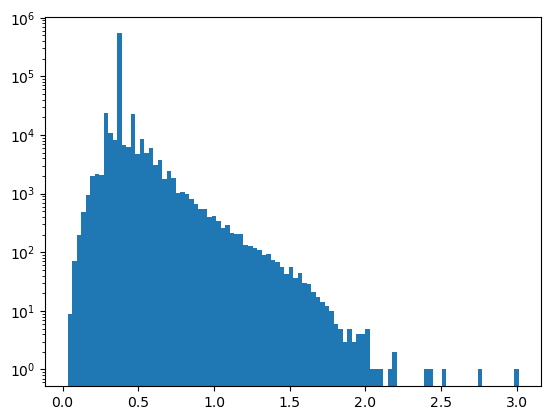

In [18]:
from rbm_torch.utils import data_prep as dp
dp.quick_hist(dp.log_scale(ndf["Final_Fold_Avg"].to_list(), eps=1, base=10))

In [14]:
ndf["fitness_value"] = dp.scale_values_np(dp.log_scale(ndf["Final_Fold_Avg"].to_list(), eps=1, base=10), min=0.05, max=1.0).squeeze(1).tolist()

In [ ]:
dp.dataframe_to_fasta(ndf, "./cov/carried_full")

In [15]:
r1_data = full_data[full_data["round"] == "r1"]
r2_data = full_data[full_data["round"] == "r2"]

r2_only = exclusive_rows(r2_data, all_seqs_pd, "sequence")

r2_sub = exclusive_rows(r2_only, r1_data, "sequence")

In [16]:
background = r2_sub.sample()

7621592

In [13]:
r1_only.head()

,sequence,copy_num,round,assignment,r10,r11,r12,r7,r8,r9,r4,r5,r6,_merge
0,CCTTCGTGGCGCAATAGAGCCTAACTAATCGCCCCAACGT,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,TGGGTGAAACGTAGGGCTGATTAGGGTCCTGGCAATAACC,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,CGTTGGGTGGTATGTGCCGGTGTAATAAGATCAAATCATT,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,TGTTAGACGACCACGTATATGGTTCTTGGTCTCGCCCTCG,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,CCGGGACAGAGTTCTCGATAACGGCGCCTAAGGGAAACCC,1.0,r1,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [20]:
r2_sub.index.__len__()

7621592

In [26]:
r7_data = full_data[full_data["round"] == "r7"]

r7_only = exclusive_rows(r7_data, all_seqs_pd, "sequence")

In [27]:
r7_only.index.__len__()

1899861

In [29]:
r7_sub = exclusive_rows(r7_only, r2_sub, "sequence")

In [30]:
r7_sub.index.__len__()

1871316

In [58]:
r7_sample = r7_sub.sample(100000)
r7_sample["fitness_value"] = [0.0001 for i in range(100000)]
# dp.dataframe_to_fasta(r7_sample, "./cov/mid_sample.fasta", count_key="fitness_value")

In [59]:
r2_sample = r2_sub.sample(100000)
r2_sample["fitness_value"] = [0.00001 for i in range(100000)]
# dp.dataframe_to_fasta(r2_sample, "./cov/bad_sample.fasta", count_key="fitness_value")

In [25]:
good_binders = am.fetch_data(["en_avg_g3"], dir="./cov/", molecule="dna")

Process Time 0.2580568790435791


In [43]:
pruned_r7_sample = prune_similar_sequences_df(r7_sample, good_binders, hamming_threshold=1)

Kept 70080 of 75000 in df1


In [60]:
r7_good_dists = prune_similar_sequences_df(r7_sample, good_binders, hamming_threshold=2, return_min_distances=True)

In [62]:
r2_good_dists = prune_similar_sequences_df(r2_sample, good_binders, hamming_threshold=2, return_min_distances=True)

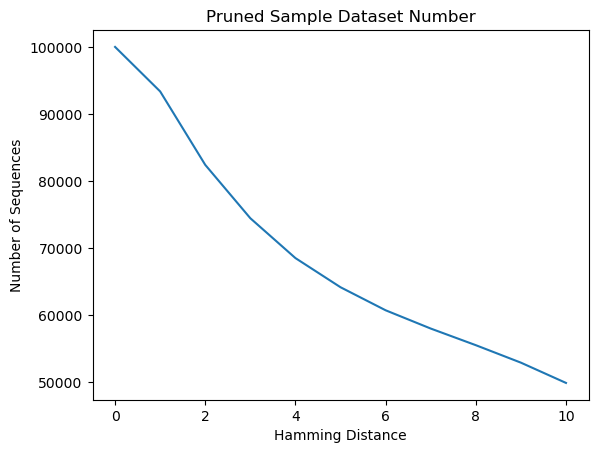

In [61]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
hamming_dists = np.arange(0, 11, 1).tolist()
number_of_seqs =[sum(i > d for i in r7_good_dists) for d in hamming_dists]
axs.plot(hamming_dists, number_of_seqs)
axs.set_xlabel("Hamming Distance")
axs.set_ylabel("Number of Sequences")
axs.set_title("Pruned Sample Dataset Number")
plt.show()

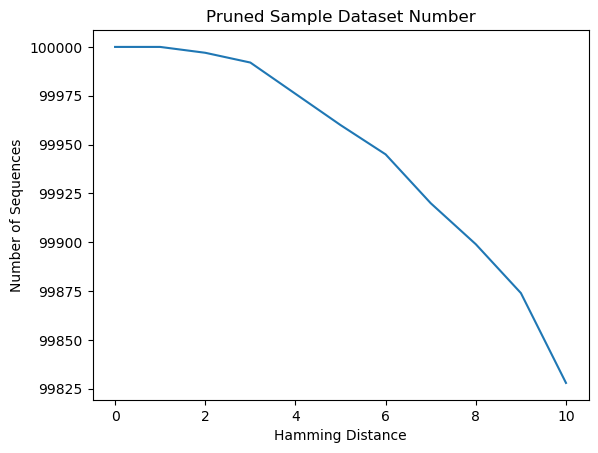

In [63]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
hamming_dists = np.arange(0, 11, 1).tolist()
number_of_seqs =[sum(i > d for i in r2_good_dists) for d in hamming_dists]
axs.plot(hamming_dists, number_of_seqs)
axs.set_xlabel("Hamming Distance")
axs.set_ylabel("Number of Sequences")
axs.set_title("Pruned Sample Dataset Number")
plt.show()

In [64]:
# Prepare sample of 75000 sequences with 2 mutations of more away from any sequence in the good binders
keep_r2 = r2_sample.iloc[:75000, :]

r7_keep = np.asarray(r7_good_dists) > 1
r7_select = r7_sample.iloc[r7_keep, :]
r7_select.reset_index(drop=True, inplace=True)

keep_r7 = r7_select.iloc[:75000, :]

dp.dataframe_to_fasta(keep_r7, "./cov/mid_sample.fasta", count_key="fitness_value")
dp.dataframe_to_fasta(keep_r2, "./cov/bad_sample.fasta", count_key="fitness_value")

In [71]:
r7_cns = r7_data["copy_num"].tolist()

In [75]:
print(len([x for x in r7_cns if x >= 3]))

r7_ne = copy(r7_data[r7_data["copy_num"] >= 3])

r7_ne_only = exclusive_rows(r7_ne, all_seqs_pd, "sequence")




228213


In [76]:
r7_ne_only.index.__len__()

35596

In [77]:
r7_ne_good_dists = prune_similar_sequences_df(r7_ne_only, good_binders, hamming_threshold=2, return_min_distances=True)

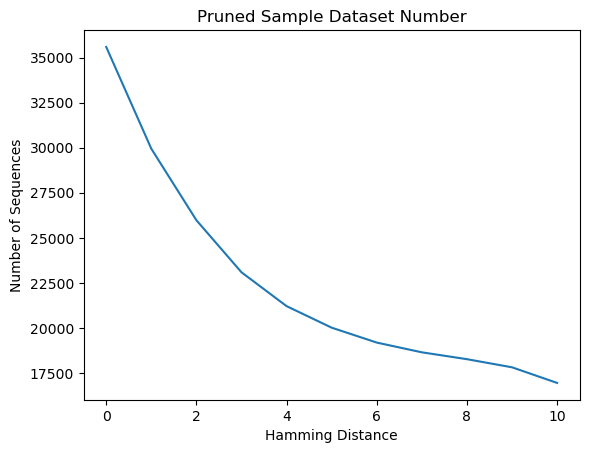

In [78]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
hamming_dists = np.arange(0, 11, 1).tolist()
number_of_seqs =[sum(i > d for i in r7_ne_good_dists) for d in hamming_dists]
axs.plot(hamming_dists, number_of_seqs)
axs.set_xlabel("Hamming Distance")
axs.set_ylabel("Number of Sequences")
axs.set_title("Pruned Sample Dataset Number")
plt.show()

In [6]:
from rbm_torch.utils.seq_utils import seq_to_cat
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances_chunked
import numpy as np

def prune_similar_sequences_df(df1, df2, hamming_threshold=0, molecule="protein", return_min_distances=False):
    """generate subset of sequences in df1 that are at least x mutations away from all sequences in df2"""
    df1.reset_index(drop=True, inplace=True)
    df1_seqs = df1["sequence"].tolist()
    df1_index = df1.index.tolist()

    df1_cat = seq_to_cat(df1_seqs, molecule=molecule)
    X = df1_cat.numpy().astype(np.int8)

    df2.reset_index(drop=True, inplace=True)
    df2_seqs = df2["sequence"].tolist()
    df2_index = df2.index.tolist()

    df2_cat = seq_to_cat(df2_seqs, molecule=molecule)
    Y = df2_cat.numpy().astype(np.int8)

    seq_len = len(df1_seqs[0])


    def reduce_func(D_chunk, start):
        # print(D_chunk)
        return np.asarray(D_chunk).min(1).tolist()

    min_distances_chunked = pairwise_distances_chunked(X, Y, reduce_func=reduce_func, metric="hamming")

    mdists = []
    for n1 in min_distances_chunked:
        mdists += n1

    if return_min_distances:
        return [x* seq_len for x in mdists]
    else:
        keep = np.asarray(mdists)*seq_len > hamming_threshold

        dataframe = df1.iloc[keep, :]

        print(f"Kept {dataframe.index.__len__()} of {df1.index.__len__()} in df1")

        dataframe.reset_index(drop=True, inplace=True)
        return dataframe


In [5]:
def enrichment_averge(df, round_names, min_diff=1, max_diff=None, diff_weights=None, round_weights=None):
    round_number = len(round_names)

    if max_diff is None:
        max_diff = round_number-1

    if diff_weights is None:
        diff_weights = [1. for x in range(min_diff, max_diff+1)]

    if round_weights is None:
        round_weights = [1. for x in range(len(round_names))]

    # first let's remove all the nan values in the dataframe, set nan values as the minimum normalized count for each round
    for r in round_names:
        df[r] = df[r].fillna(df[r].min())

    # Get fold value for round differences
    fold_keys = {diff: [] for diff in range(min_diff, max_diff+1)}
    for i in range(round_number):
        for j in range(round_number):
            if i >= j or j - i < min_diff or j - i > max_diff:
                continue
            fold_column_name = f"fold_{round_names[j]}v{round_names[i]}"
            fold_keys[j-i].append(fold_column_name)
            # fold_diffs.append(j-i)
            df[fold_column_name] = df[round_names[j]]/df[round_names[i]] * (round_weights[j] + round_weights[i])

    diff_keys = []
    for i in range(min_diff, max_diff+1):
        diff_avg_key = f"fold_diff{i}_avg"
        df[diff_avg_key] = df[fold_keys[i]].sum(axis=1).div(len(fold_keys[i])).mul(diff_weights[i-1])
        diff_keys.append(diff_avg_key)

    df["Final_Fold_Avg"] = df[diff_keys].sum(axis=1).div(len(diff_keys))

    return df